In [3]:
import os
os.chdir("..")

In [4]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [5]:
from PIL import Image
from numpy import random
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from ultralytics import YOLO
from api.metrics import apply_grey_patch, add_random_noise_to_image
from api.metrics import normalize, match_hist, normalize_map #metrics preprocessing
from api.metrics import SIM, CC, NSS, AUC_Judd

from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

from commons.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from commons.ScoreCAM.utils.visualize import visualize, reverse_normalize
from commons.ScoreCAM.utils.imagenet_labels import label2idx, idx2label

import scipy.stats as sci

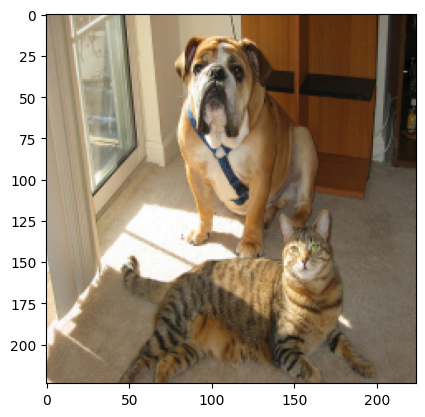

In [6]:
image = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
# image = keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)
imshow(image)

In [7]:
def preprocessing(image):
    # Resize the image
    size = (300, 300)
    image = image.resize(size)
    
    # preprocessing. mean and std from ImageNet
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    # convert image to tensor
    tensor = preprocess(image)

    # reshape 4D tensor (N, C, H, W)
    tensor = tensor.unsqueeze(0)
    
    return tensor

In [8]:
tensor = preprocessing(image)
tensor.shape

torch.Size([1, 3, 300, 300])

In [9]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
model.eval()

Using cache found in /home/smitra/.cache/torch/hub/pytorch_vision_v0.10.0
/scratch/smitra/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/smitra/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
gpu_reference_tensor = next(model.parameters())
tensor = tensor.type_as(gpu_reference_tensor)

In [11]:
target_layer = model.layer4[1].conv2
classes = open("/project/validating_attribution_techniques/shardul/classes.txt").read().splitlines()

In [13]:
def scoreCAM(target_layer, model, tensor):
    wrapped_model = ScoreCAM(model, target_layer)
    cam, idx = wrapped_model(tensor)
    return cam, idx

In [14]:
def saliency_map(tensor, cam):
#     tensor = tensor.cpu()
    img = reverse_normalize(tensor)
    heatmap = visualize(img, cam)
    heatmap = np.transpose(heatmap.squeeze(), (1, 2, 0))
    return heatmap

In [15]:
cam, idx = scoreCAM(target_layer, model, tensor)
cam = cam.cpu()

Text(0.5, 1.0, 'Class: bull_mastiff')

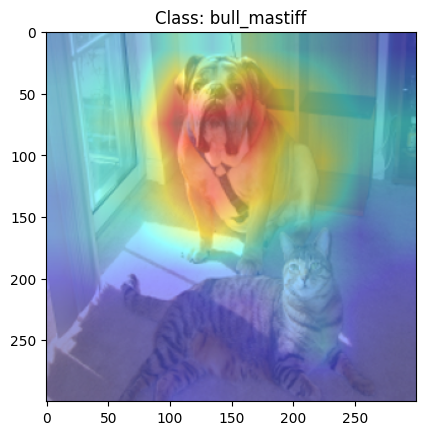

In [16]:
fig, ax = plt.subplots()
heatmap = saliency_map(tensor, cam)
ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {classes[idx]}")

In [20]:
def gradCAM(target_layer, model, tensor):
    wrapped_model = GradCAM(model, target_layer)
    cam, idx = wrapped_model(tensor)
    return cam, idx

In [21]:
cam, idx = gradCAM(target_layer, model, tensor)
cam = cam.cpu()

/scratch/smitra/python/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 282	 probability 0.16280797123908997


In [12]:
def smoothGradCAMpp(target_layer, model, tensor):
    wrapped_model = SmoothGradCAMpp(model, target_layer)
    cam, idx = wrapped_model(tensor)
    return cam, idx

In [13]:
cam, idx = smoothGradCAMpp(target_layer, model, tensor)
cam = cam.cpu()

/scratch/smitra/python/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 243	 probability 0.0789218470454216
